## Data Cleaning

### 1. Drop null and duplicates

In [18]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely import wkt

In [2]:
tree_species = pd.read_csv('Tree_Inventory-Species.csv')

In [3]:
tree_species.isnull().sum()

GEOMETRY                     0
SPECIES                     64
DIAMETER                     0
LATITUDE                     0
LONGTITUDE                   0
New Georeferenced Column     0
dtype: int64

In [4]:
tree_species.dropna(inplace=True)
tree_species.drop_duplicates(keep='last', inplace=True)

### 2. Combine species with same name

In [5]:
to_remove = ['Cedar Elm', 'Oak, Live (Southern)', 'Ashe Juniper', 'Bur Oak', 'Crape Myrtle (including hybrids)', 'Hackberry, Common']
combine_to = ['Elm, Cedar', 'Southern Live Oak', 'Juniper, Ashe', 'Oak, Bur', 'Crapemyrtle', 'Hackberry']

for i in range(len(to_remove)):
    tree_species.loc[tree_species['SPECIES'] == to_remove[i], 'SPECIES'] = combine_to[i]

In [6]:
tree_species['SPECIES'].value_counts()[:20]

Southern Live Oak                       9753
Elm, Cedar                              8787
Pecan                                   4243
Crapemyrtle                             3762
Juniper, Ashe                           2526
Oak, Texas Live (Escarpment)            2079
Hackberry                               1909
Oak, Bur                                1489
Sugarberry                              1152
Stump                                    981
Red Oak                                  868
Cedar, Eastern Red                       790
Oak, Chinquapin                          661
Oak, Texas Red                           651
Bean, Mescal (Texas Mountain Laurel)     623
Elm, American                            621
Vacant Planting Site - Small             610
Escarpment Live Oak                      591
Shumard Oak                              551
Cypress, Bald                            524
Name: SPECIES, dtype: int64

In [7]:
# There are species labeled as Unknown, we remove them
#(tree_species['SPECIES'] == 'Unknown').sum()

tree_species.drop(tree_species.loc[tree_species['SPECIES']=='Unknown'].index, inplace=True)

In [8]:
# Save cleaned tree species data as a shape file

tree_species_geo = gpd.GeoDataFrame(tree_species)
tree_species_geo.set_geometry(
    gpd.points_from_xy(tree_species_geo['LONGTITUDE'], tree_species_geo['LATITUDE']),
    inplace=True, crs='EPSG:4326')
tree_species_geo.to_file('Austin_Tree_Species_Clean.shp')  

<ipython-input-8-f86b3b35e7d9>:7: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  tree_species_geo.to_file('Austin_Tree_Species_Clean.shp')


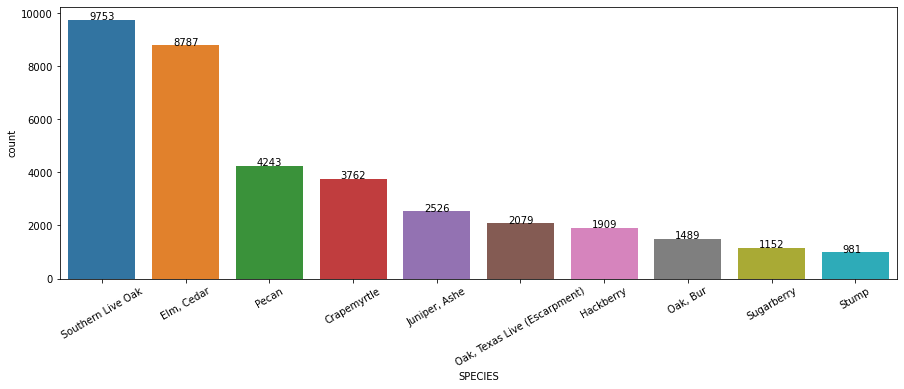

In [9]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x=tree_species['SPECIES'], order=tree_species['SPECIES'].value_counts().iloc[:10].index)
ax.tick_params(axis='x', rotation=30)
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.show()

### 3. Associate Species info with polygons

For our final training data, we only keep the species that are located within the polygons.

In [10]:
polygons = gpd.read_file('austin_region2_tree_segments.shp')
species_points = gpd.read_file('Austin_Tree_Species_Clean.shp')

In [11]:
# CRS reprojection
polygons = polygons.to_crs(epsg=4326)
print('polygons crs: ', polygons.crs)
print('points crs: ', species_points.crs)

polygons crs:  epsg:4326
points crs:  epsg:4326


In [14]:
# Join the polygons and the points

polygons_species = gpd.sjoin(polygons, species_points)
# polygons_species.to_file('polygons_species.shp')

<ipython-input-14-b2a946a994a9>:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  polygons_species.to_file('polygons_species.shp')


In [17]:
polygons_species.drop(columns=['index_right','GEOMETRY','DIAMETER','LATITUDE','LONGTITUDE','New Georef'],
                      inplace=True)

In [20]:
# Make polygon geometry a string column
polygons_species['str_geometry'] = polygons_species.geometry.apply(lambda x: wkt.dumps(x))

# For each polygon, select the most common species
polygons_species = polygons_species.groupby(['str_geometry', 'heights'])['SPECIES'].apply(lambda x: x.value_counts().index[0]).reset_index()

# Change string geometry back to geometry and output as a new shapefile
polygons_species['geometry'] = polygons_species['str_geometry'].apply(lambda x: wkt.loads(x))
polygons_species.drop(columns='str_geometry', inplace=True)
polygons_species = gpd.GeoDataFrame(data=polygons_species, geometry=polygons_species['geometry'], crs=4326)
polygons_species.to_file('polygons_species.shp')

In [21]:
polygons_species['SPECIES'].value_counts()[:20]

Pecan                           972
Elm, Cedar                      914
Southern Live Oak               597
Crapemyrtle                     241
Oak, Post                       200
Oak, Texas Live (Escarpment)    155
Sugarberry                      136
Elm, American                   127
Juniper, Ashe                    98
Hackberry                        74
Live Oak                         63
Privet, Japanese                 55
Chinaberrytree                   50
Oak, Texas Red                   50
Cedar, Eastern Red               47
Tallow, Chinese                  46
Oak, Bur                         44
Mesquite, Honey                  43
American Sycamore                42
Post Oak                         37
Name: SPECIES, dtype: int64

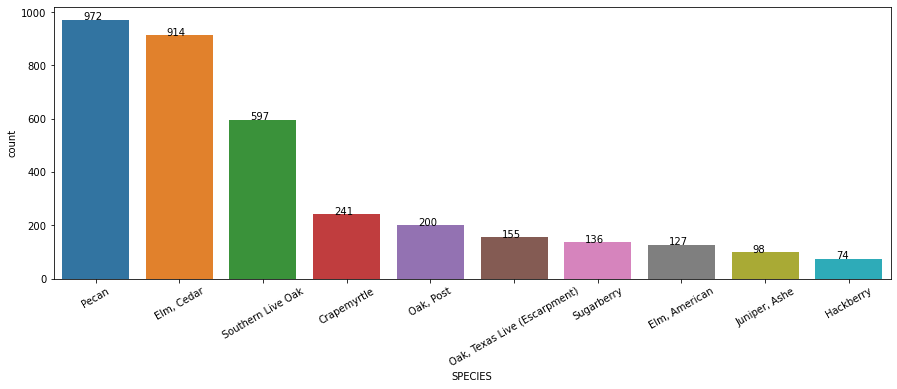

In [22]:
# After matching each polygon to a single species
# We now plot the histogram of all the polygon species

plt.figure(figsize=(15,5))
ax = sns.countplot(x=polygons_species['SPECIES'], order=polygons_species['SPECIES'].value_counts().iloc[:10].index)
ax.tick_params(axis='x', rotation=30)
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.show()

In [14]:
# To test if the polygons_species is correct, use QGIS manual check

points_in_polygons = gpd.sjoin(species_points, polygons)
points_in_polygons.to_file('points_in_polygons.shp')

<ipython-input-14-a12102a4d731>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  points_in_polygons.to_file('points_in_polygons.shp')


### 4. Associate Species info with every pixel within polygons

In [25]:
import rasterio
import rasterio.mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import fiona

In [26]:
# Transform projection of austin imagery to specific coordinate system

# Specify output projection system
dst_crs = 'EPSG:4326'

# Input imagery file name before transformation
austin_sw_file = 'm_3009743_sw_14_060_20201018.tif'
# Save output imagery file name after transformation
transformed_imagery_file = 'austin_sw_4326.tif'

with rasterio.open(austin_sw_file) as imagery:
    transform, width, height = calculate_default_transform(imagery.crs, dst_crs, imagery.width, imagery.height, *imagery.bounds)
    kwargs = imagery.meta.copy()
    kwargs.update({'crs': dst_crs, 'transform': transform, 'width': width, 'height': height})
    with rasterio.open(transformed_imagery_file, 'w', **kwargs) as dst:
        for i in range(1, imagery.count + 1):
            reproject(
                source=rasterio.band(imagery, i),
                destination=rasterio.band(dst, i),
                src_transform=imagery.transform,
                src_crs=imagery.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [27]:
austin_sw = rasterio.open('austin_sw_4326.tif')
austin_sw.crs

CRS.from_epsg(4326)

In [28]:
# Clip the raster file with polygons

# Read Shape file
with fiona.open('polygons_species.shp', "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

# read imagery file
with rasterio.open('austin_sw_4326.tif') as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

# Save clipped imagery
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open('austin_sw_crop.tif', "w", **out_meta) as dest:
    dest.write(out_image)

/Users/kennywu/opt/anaconda3/lib/python3.8/site-packages/rasterio/mask.py:191: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  out_image = dataset.read(


## Determine Final Species

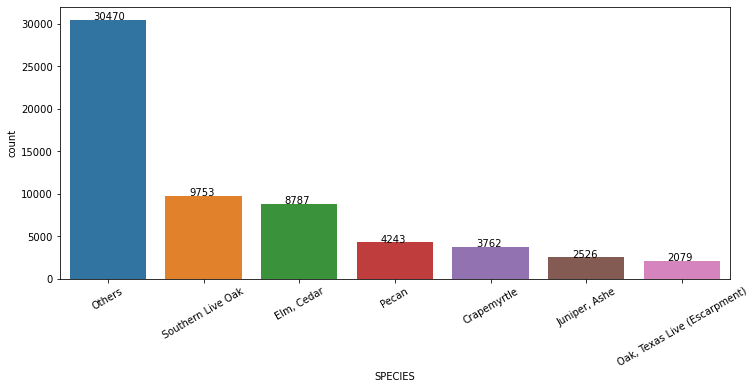

In [11]:
# Decide final classification species ????????

final_species = ['Southern Live Oak', 'Elm, Cedar', 'Pecan', 'Crapemyrtle', 'Juniper, Ashe', 'Oak, Texas Live (Escarpment)']
tree_species.loc[~(tree_species['SPECIES'].isin(final_species)), 'SPECIES'] = 'Others'

plt.figure(figsize=(12,5))
ax = sns.countplot(x=tree_species['SPECIES'], order=tree_species['SPECIES'].value_counts().index)
ax.tick_params(axis='x', rotation=30)
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.show()